<a href="https://colab.research.google.com/github/mrzResearchArena/ACP/blob/master/ACP-500-164.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [1]. Google Drive Initialization:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
ls

drive/  sample_data/


In [5]:
cd 'drive/My Drive/Colab-Notebooks'

/content/drive/My Drive/Colab-Notebooks


In [6]:
ls -1

0_FINAL_anti_peptide_model_AC240-tensorboard.ipynb
0_FINAL_anti_peptide_model_ACP740-tensorboard.ipynb
500-164.h5
544_encoded_sequences_740.npy
ACP164.npy
ACP240_labels.npy
acp240.txt
ACP500.npy
ACP740_labels.npy
ACP-740-tensorboard.ipynb
acp740.txt
blosum62-acp240.npy
blosum62-acp740.npy
BPF_coded_ACP164_sequences.npy
BPF_coded_ACP240_sequences.npy
BPF_coded_ACP500_sequences.npy
BPF_coded_ACP740_sequences.npy
kmer_k_3_ACP240.npy
kmer_k_3_ACP740.npy
logs/
mACP-240.ipynb
mACP-740.ipynb
model-240.png
model-500-164.png
model-740.png
model.png
multichannel.png
physico_coded_ACP164_sequences.npy
physico_coded_ACP240_sequences.npy
physico_coded_ACP500_sequences.npy
physico_coded_ACP740_sequences.npy


## [2]. Load Deep Learning API (Keras):

In [7]:
# Deep Neural Networks:
from keras.layers import (Input, Dense, Dropout, Flatten, BatchNormalization,
                          Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, concatenate,
                          SimpleRNN, LSTM, GRU, Bidirectional, Embedding)
from keras.regularizers import (l1, l2, l1_l2)
from keras.optimizers import (RMSprop, Adam, SGD)
from keras.models import (Sequential, Model)
import keras; print('We\'re using Keras version: {}.'.format(keras.__version__))

# Core:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Performance:
from sklearn.metrics import (confusion_matrix, classification_report, mean_squared_error, 
                             matthews_corrcoef, precision_score)

#Utilities
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import to_categorical as labelEncoding # Usages: Ytrain = labelEncoding(Ytrain, dtype=int)
from keras.utils import plot_model                      # Usages: plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, expand_nested=True)
from sklearn.model_selection import (StratifiedKFold, KFold, train_test_split)
#end-import

Using TensorFlow backend.


We're using Keras version: 2.2.5.


## [3]. Load Datasets:

In [8]:
D = 20    # terminus_length

X1train = np.load('BPF_coded_ACP500_sequences.npy')
X2train = np.load('physico_coded_ACP500_sequences.npy')
X3train = np.load('ACP500.npy')

X3train = X3train.reshape(-1, 20, 11)

print(X1train.shape)
print(X2train.shape)
print(X3train.shape)
print('### --- --- --- --- --- ###')

X2train = X2train[:,:,0:25]
print(X1train.shape)
print(X2train.shape)
print(X3train.shape)

### -----------------------------------------------------
X1test = np.load('BPF_coded_ACP164_sequences.npy')
X2test = np.load('physico_coded_ACP164_sequences.npy')
X3test = np.load('ACP164.npy')

X3test = X3test.reshape(-1, 20, 11)

print(X1test.shape)
print(X2test.shape)
print(X3test.shape)

X2test = X2test[:,:,0:25]

print(X1test.shape)
print(X2test.shape)
print(X3test.shape)

print('### --- --- --- --- --- ###')

# ACP {500, 164}
Ytrain  = [0 for _ in range(250)]
Ytrain += [1 for _ in range(250)]
Ytrain  = np.array(Ytrain)

Ytest  = [0 for _ in range(82)]
Ytest += [1 for _ in range(82)]


Ytrain = labelEncoding(Ytrain, dtype=int)
Ytest  = labelEncoding(Ytest, dtype=int)

(500, 20, 11)
(500, 7, 207)
(500, 20, 11)
### --- --- --- --- --- ###
(500, 20, 11)
(500, 7, 25)
(500, 20, 11)
(164, 20, 11)
(164, 7, 207)
(164, 20, 11)
(164, 20, 11)
(164, 7, 25)
(164, 20, 11)
### --- --- --- --- --- ###


In [0]:
def lossPlot(results):
    plt.title(label='Loss: Training and Validation')
    plt.plot(results.history['loss'], label='Training Loss')
    plt.plot(results.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
#end-def

def accuracyPlot(results):
    plt.title(label='Accuracy: Training and Validation')
    plt.plot(results.history['acc'], label='Training Accuracy')
    plt.plot(results.history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
#end-def

## [4]. Generate Model:

In [0]:
def Network():
    ### Head-1:
    input1 = Input(shape=(20, 11)) # T=20

    # x = Conv1D(filters=64, kernel_size=3, padding='same', data_format='channels_first', activation='relu',)(input1)
    # x = BatchNormalization()(x)
    # x = Dropout(rate=0.70)(x)

    # x = Conv1D(filters=32, kernel_size=3, padding='same', data_format='channels_first', activation='relu',)(x)
    # x = BatchNormalization()(x)
    # x = Dropout(rate=0.70)(x)

    x = Conv1D(filters=16, kernel_size=3, padding='same', data_format='channels_first', activation='relu', kernel_regularizer=l2(l=0.01))(input1)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.75)(x)

    x = Conv1D(filters=12, kernel_size=3, padding='same', data_format='channels_first',activation='relu', kernel_regularizer=l2(l=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.75)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', data_format='channels_first', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.75)(x)

    head1 = Flatten()(x)


    ### Head-2:
    input2 = Input(shape=(7, 25)) # T=7

    # x = Conv1D(filters=32, kernel_size=3, padding='same', data_format='channels_first', activation='relu',)(input2)
    # x = BatchNormalization()(x)
    # x = Dropout(rate=0.70)(x)

    x = Conv1D(filters=16, kernel_size=3, padding='same', data_format='channels_first',activation='relu', kernel_regularizer=l2(l=0.01))(input2)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.75)(x)

    x = Conv1D(filters=12, kernel_size=3, padding='same', data_format='channels_first',activation='relu', kernel_regularizer=l2(l=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.75)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', data_format='channels_first', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.75)(x)

    head2 = Flatten()(x)


    ### Head-3:
    input3 = Input(shape=(20, 11))

    # x = Conv1D(filters=64, kernel_size=3, padding='same', data_format='channels_first', activation='relu',)(input3)
    # x = BatchNormalization()(x)
    # x = Dropout(rate=0.70)(x)

    # x = Conv1D(filters=32, kernel_size=3, padding='same', data_format='channels_first', activation='relu',)(x)
    # x = BatchNormalization()(x)
    # x = Dropout(rate=0.70)(x)

    x = Conv1D(filters=16, kernel_size=3, padding='same', data_format='channels_first',activation='relu', kernel_regularizer=l2(l=0.01))(input3)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.75)(x)

    x = Conv1D(filters=12, kernel_size=3, padding='same', data_format='channels_first',activation='relu', kernel_regularizer=l2(l=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.75)(x)

    x = Conv1D(filters=8, kernel_size=3, padding='same', data_format='channels_first', activation='relu', kernel_regularizer=l2(l=0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.75)(x)

    head3 = Flatten()(x)


    # merge
    merge = concatenate(inputs=[head1, head2, head3])
    
    output = Dense(units=16, activation='relu', kernel_regularizer=l2(l=0.01))(merge)
    output = BatchNormalization()(output)
    output = Dropout(rate=0.75)(output)

    output = Dense(units=12, activation='relu', kernel_regularizer=l2(l=0.01))(output)
    output = BatchNormalization()(output)
    output = Dropout(rate=0.75)(output)


    output = Dense(units=8, activation='relu', kernel_regularizer=l2(l=0.01))(output)
    output = BatchNormalization()(output)
    output = Dropout(rate=0.75)(output)

    output = Dense(units=2, activation='softmax')(output)

    return Model(inputs=[input1, input2, input3], outputs=[output])
#end-def

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 20, 11)       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 7, 25)        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 20, 11)       0                                            
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 16, 11)       976         input_7[0][0]                    
____________________________________________________________________________________________

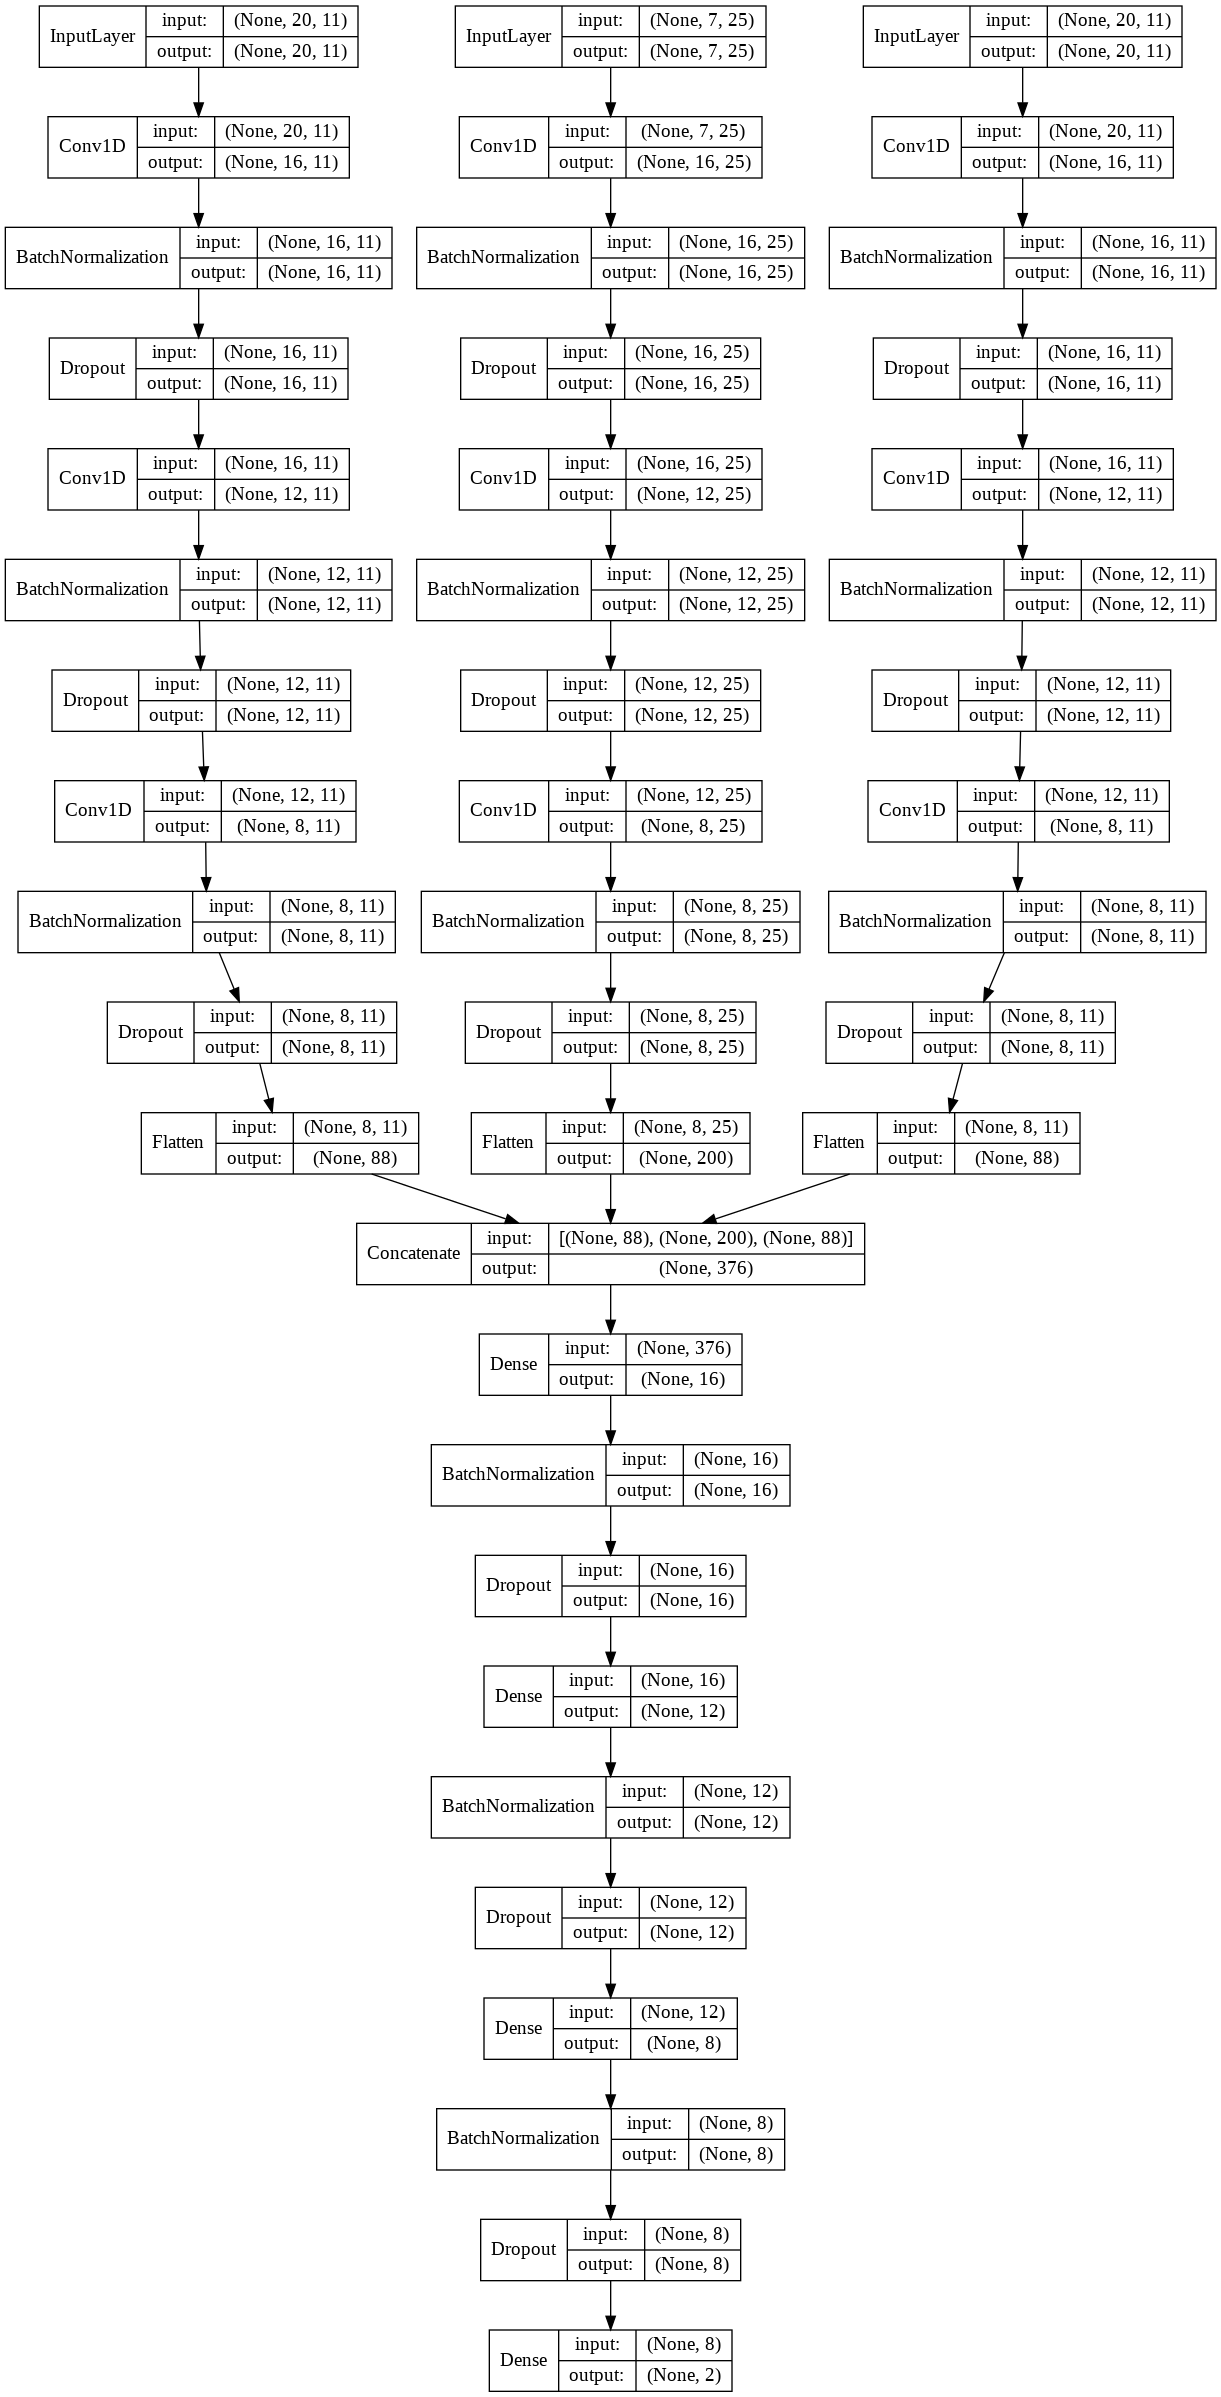

In [14]:
model = Network()
model.summary()
plot_model(model, to_file='model-500-164.png', show_shapes=True, show_layer_names=False, expand_nested=True)

## [5]. Run Model:

Train on 500 samples, validate on 164 samples
Epoch 1/1500
500/500 [==============================] - 8s 15ms/step - loss: 2.6821 - acc: 0.5020 - val_loss: 2.3928 - val_acc: 0.5000
Epoch 2/1500
500/500 [==============================] - 1s 2ms/step - loss: 2.6756 - acc: 0.4980 - val_loss: 2.3830 - val_acc: 0.5000
Epoch 3/1500
500/500 [==============================] - 1s 2ms/step - loss: 2.6004 - acc: 0.4920 - val_loss: 2.3688 - val_acc: 0.5000
Epoch 4/1500
500/500 [==============================] - 1s 2ms/step - loss: 2.6203 - acc: 0.4700 - val_loss: 2.3566 - val_acc: 0.5000
Epoch 5/1500
500/500 [==============================] - 1s 3ms/step - loss: 2.5222 - acc: 0.5620 - val_loss: 2.3452 - val_acc: 0.5000
Epoch 6/1500
500/500 [==============================] - 1s 3ms/step - loss: 2.5654 - acc: 0.4960 - val_loss: 2.3366 - val_acc: 0.5000
Epoch 7/1500
500/500 [==============================] - 1s 3ms/step - loss: 2.6024 - acc: 0.4940 - val_loss: 2.3291 - val_acc: 0.5000
Epoch 8/1500
50

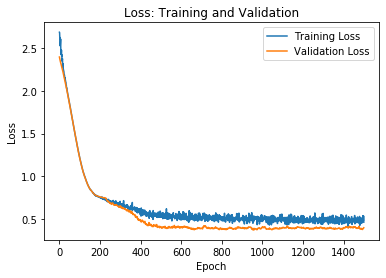

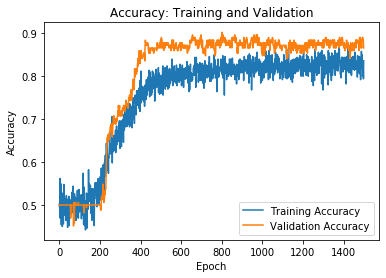

In [17]:
# Setting epoch and batch number
setEpochNumber     = 1500      # 2,500 performed well.
setBatchSizeNumber = 16

# Compile Model:
model = Network()
model.compile(optimizer=Adam(lr=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
              # Adam(lr=0.0001)

# Run Model:
results = model.fit(x=[X1train, X2train, X3train],
                    y=[Ytrain], 
                    validation_data=([X1test, X2test, X3test], [Ytest]),
                    epochs=setEpochNumber,
                    batch_size=setBatchSizeNumber,
                    verbose=1)

# Evaluate the Model:
accuracy = model.evaluate(x=[X1test, X2test, X3test], y=Ytest)

# Performance Metices:
Yactual = Ytest.argmax(axis=1)
Yp = model.predict([X1test, X2test, X3test])
Yp = Yp.argmax(axis=1)

CM = confusion_matrix(y_pred=Yp, y_true=Yactual)
TN, FP, FN, TP = CM.ravel()


print('Accuracy: {:.2f}'.format(accuracy[1]))
print('MCC: {:.2f}'.format(matthews_corrcoef(y_true=Yactual, y_pred=Yp)))
print('Sensitivity: {0:.4f}'.format(TP / (TP + FN)))
print('Specificity: {0:.4f}'.format(TN / (TN + FP)))
print('Precision: {0:.4f}'.format(precision_score(y_true=Yactual, y_pred=Yp)))


# Performance Plot
lossPlot(results)
accuracyPlot(results)

In [0]:
model.save('ACP-500-164.h5')